# Final Project

## Team Members

- **Mohit Kale** – ID: __1336809__
- **Srivatsav Yallapragada** – ID: __1338663__
- **Geeta Sneha** – ID: __1338467__
- **Deepak** – ID: __1329946__


# Unemployment Rate

## 📊 Dataset Descriptions

### 1. **UNRATE.csv** – *Unemployment Rate in the U.S.*
- **Source:** U.S. Bureau of Labor Statistics
- **Frequency:** Monthly
- **Time Range:** Varies (depends on available data)
- **Variable:** `UNRATE` – The seasonally adjusted civilian unemployment rate (percentage of the labor force that is unemployed).
- **Use Case:** To analyze labor market trends, economic health, and its relationship with other macroeconomic indicators.

---


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

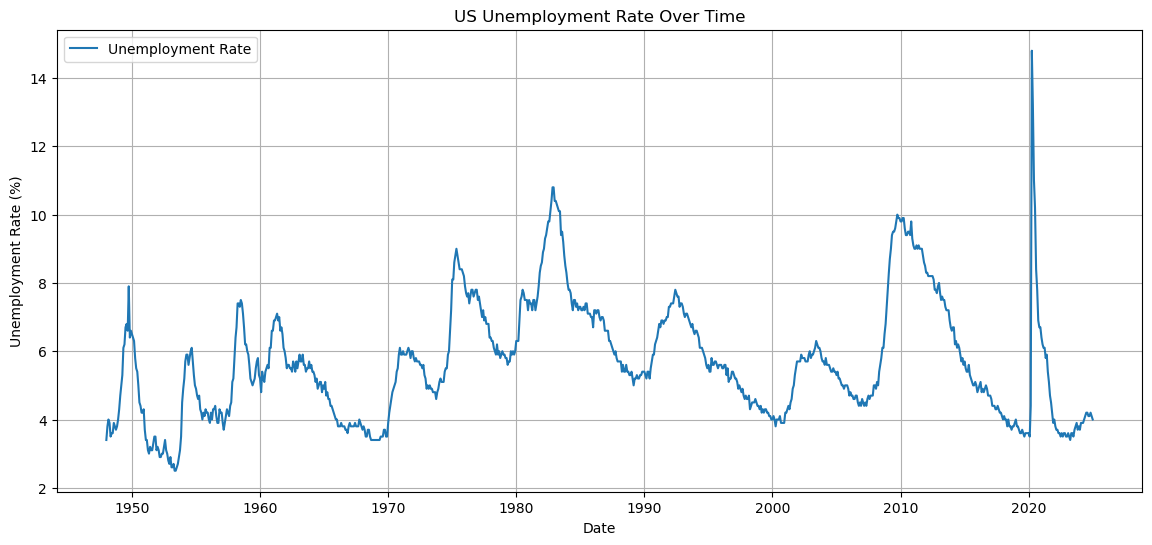

In [21]:
# Load dataset
df = pd.read_csv('UNRATE.csv', parse_dates=['observation_date'], index_col='observation_date')
df = df.rename(columns={'UNRATE': 'unrate'})

# Visualize the data
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['unrate'], label='Unemployment Rate')
plt.title('US Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

## 📉 US Unemployment Rate – Key Insights

- #### **Cyclical Pattern:** Unemployment rises during recessions and declines during recoveries.
- #### **Major Peaks:**
  - #### **Early 1980s**: Economic recession.
  - #### **2008-09**: Global financial crisis (~10%).
  - #### **2020**: COVID-19 pandemic (~14.7%) – the highest in modern history.
- #### **Strong Recovery Post-2020:** Rapid decline due to reopening and government stimulus.
- #### **Pre-COVID Low:** Unemployment was at a historic low (~3.5%) in early 2020.



## Decompose the Time Series

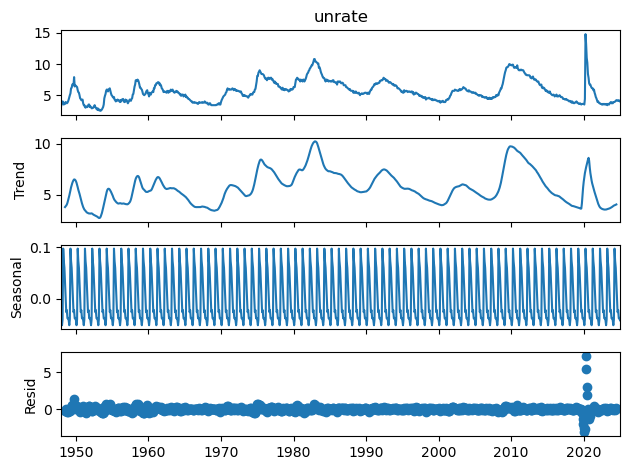

In [24]:
# Decompose using a multiplicative or additive model (we'll use additive here)
decomposition = seasonal_decompose(df['unrate'], model='additive', period=12)

# Plot decomposition
decomposition.plot()
plt.tight_layout()
plt.show()

## 🔍 Seasonal Decomposition Insights

### 📉 Unemployment Rate (UNRATE)

- **Trend:** Long-term cycles showing economic recessions (e.g., 1980s, 2008, 2020).
- **Seasonality:** Stable yearly pattern, though relatively minor in amplitude.
- **Residual:** Large residual spikes in 2020 reflect unexpected shocks due to the COVID-19 pandemic.

---

## Plot ACF and PACF

<Figure size 1200x500 with 0 Axes>

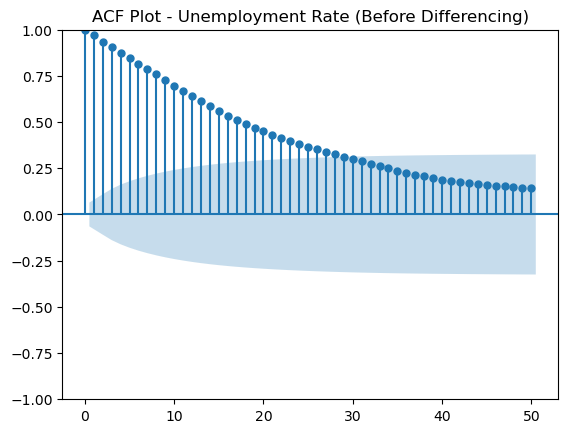

<Figure size 1200x500 with 0 Axes>

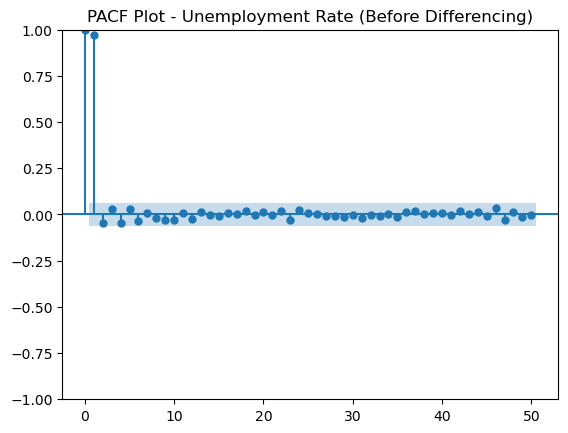

In [27]:
plt.figure(figsize=(12,5))
plot_acf(df['unrate'], lags=50)
plt.title('ACF Plot - Unemployment Rate (Before Differencing)')
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df['unrate'], lags=50, method='ywm')
plt.title('PACF Plot - Unemployment Rate (Before Differencing)')
plt.show()

## ADF Test for Stationarity

In [29]:
# Run ADF Test
adf_result = adfuller(df['unrate'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -3.909485638097965
p-value: 0.00196613652874105


### Stationarity Check: ADF Test vs ACF/PACF Analysis

The stationarity of a time series is a crucial prerequisite for applying ARIMA models. To evaluate stationarity, we used both statistical testing and visual diagnostics:

- **ADF Test Result**:  
  The Augmented Dickey-Fuller (ADF) test returned a p-value **less than 0.05**, which suggests that we can **reject the null hypothesis** of non-stationarity. This implies that the series is **statistically stationary**.

- **ACF/PACF Plots**:  
  However, the **Autocorrelation Function (ACF)** plot shows a **slowly decaying pattern**, and the **Partial Autocorrelation Function (PACF)** has strong initial spikes. This kind of behavior is often seen in **non-stationary series**, indicating the presence of a trend or long memory.

---

### Conclusion & Modeling Approach

While the ADF test suggests that **first-order differencing is not strictly necessary**, the **ACF/PACF behavior raises caution**. To reconcile this contradiction and avoid subjective bias, we employ **`auto_arima()`**, which:

- Automatically tests various ARIMA configurations.
- Selects the best model based on AIC/BIC, including whether differencing (`d`) is needed.

This data-driven approach allows us to **validate whether differencing is required**, rather than relying on a single diagnostic method.

>  _We'll use the best model selected by `auto_arima()` to guide our forecasting pipeline._

---


## Fit ARIMA Model
- Split the dataset into train/test.
- Fit the ARIMA model on the train data.
- Forecast and evaluate.

### Train-Test Split

In [33]:
n_test = 160 
train = df.iloc[:-n_test]
test = df.iloc[-n_test:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (765, 1)
Test shape: (160, 1)


In [34]:
from pmdarima import auto_arima

# Fit ARIMA model with automatic order selection
model_arima = auto_arima(train['unrate'], seasonal=False, trace=True, suppress_warnings=True)
model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-283.046, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-177.810, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-187.304, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-183.207, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-178.921, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-281.286, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-278.231, Time=0.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-282.647, Time=1.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-277.306, Time=0.70 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-247.546, Time=0.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-279.534, Time=0.75 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-277.839, Time=0.59 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-290.072, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  765
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 150.036
Date:                Tue, 06 May 2025   AIC                           -290.072
Time:                        14:34:42   BIC                           -266.879
Sample:                    01-01-1948   HQIC                          -281.143
                         - 09-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6616      0.045     37.279      0.000       1.574       1.749
ar.L2         -0.7857      0.041    -19.154      0.000      -0.866      -0.705
ma.L1         -1.6373      0.038    -43.023      0.000      -1.712      -1.563
ma.L2          0.8563      0.030     28.138      0.000       0.797       0.916
sigma2         0.0395      0.001     33.555      0.000       0.037       0.042
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):              1540.64
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ACF and PACF after fitting ARIMA model (residuals)

<Figure size 1200x500 with 0 Axes>

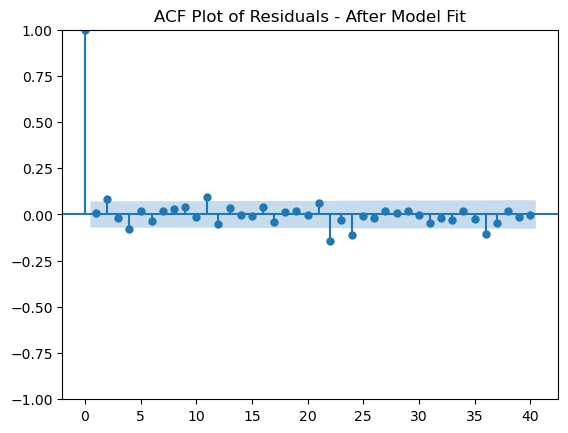

<Figure size 1200x500 with 0 Axes>

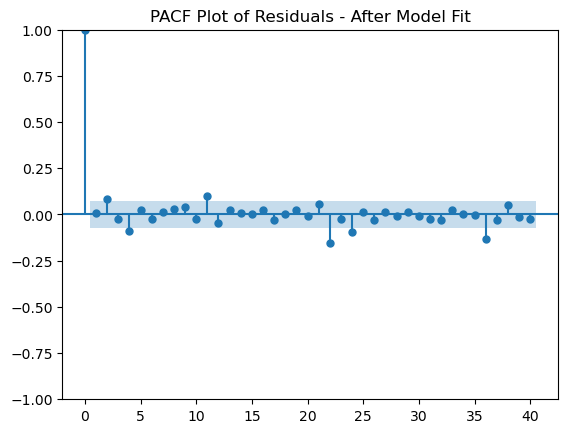

In [36]:
# Assuming 'model' is your ARIMA model fitted on 'train'

# Get residuals
residuals = pd.Series(model_arima.resid())

# Plot Residuals ACF
plt.figure(figsize=(12,5))
plot_acf(residuals, lags=40)
plt.title('ACF Plot of Residuals - After Model Fit')
plt.show()

# Plot Residuals PACF
plt.figure(figsize=(12,5))
plot_pacf(residuals, lags=40, method='ywm')
plt.title('PACF Plot of Residuals - After Model Fit')
plt.show()


## Plot Residual Diagnostics

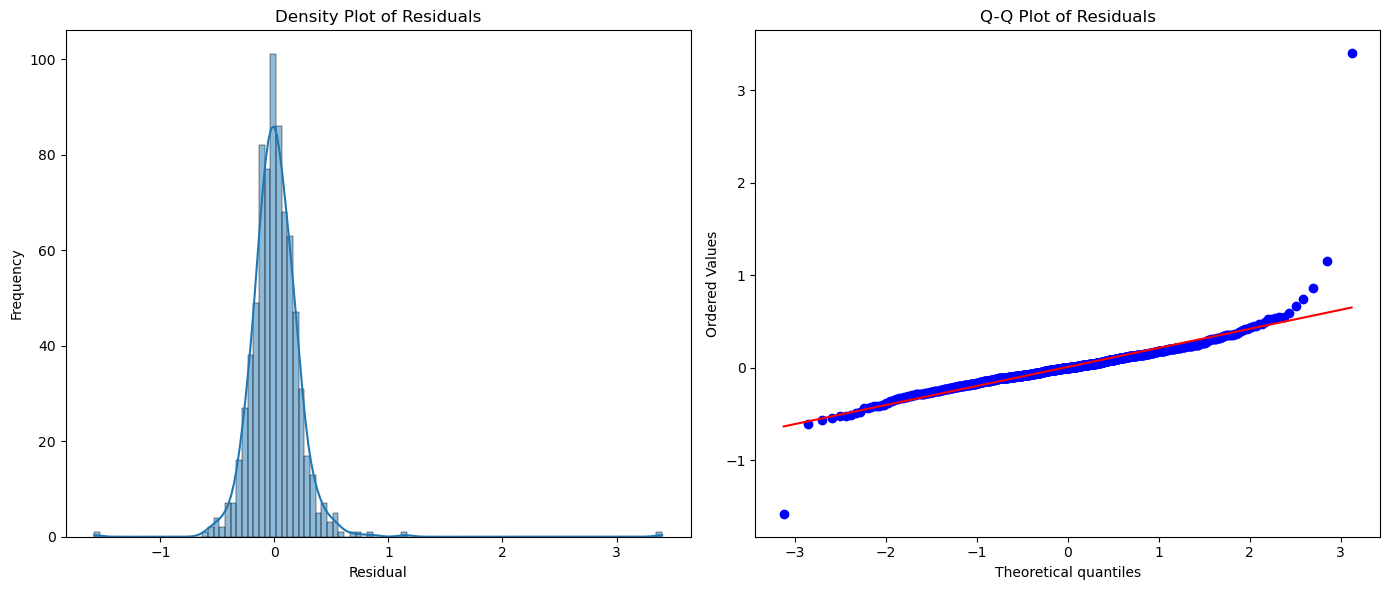

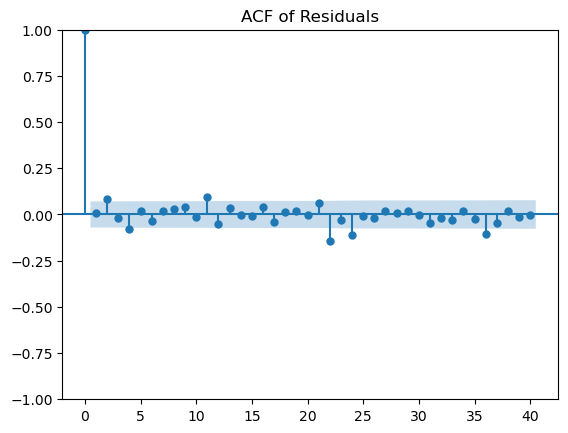

In [38]:
# Extract residuals from the fitted model
residuals = model_arima.resid()

# Plot residuals
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("Density Plot of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

### Residual Diagnostics - ARIMA Model

The residual analysis after fitting the ARIMA model reveals the following:

- **Density Plot**: Residuals are approximately normally distributed and centered around zero, indicating low bias.

- **Q-Q Plot**: Most points lie along the diagonal, suggesting near-normality. Minor deviations in tails may exist due to rare economic shocks.

- **ACF of Residuals**: Most lags fall within the 95% confidence bounds, indicating no significant autocorrelation. This confirms that the model has successfully captured temporal dependencies in the data.

 **Conclusion**: The ARIMA model fits the unemployment rate data well. The residuals show no major issues, supporting the model's validity for forecasting.


### Forecast with ARIMA(2,1,2)

observation_date
2011-10-01    9.020111
2011-11-01    9.046929
2011-12-01    9.075689
2012-01-01    9.102406
2012-02-01    9.124202
dtype: float64


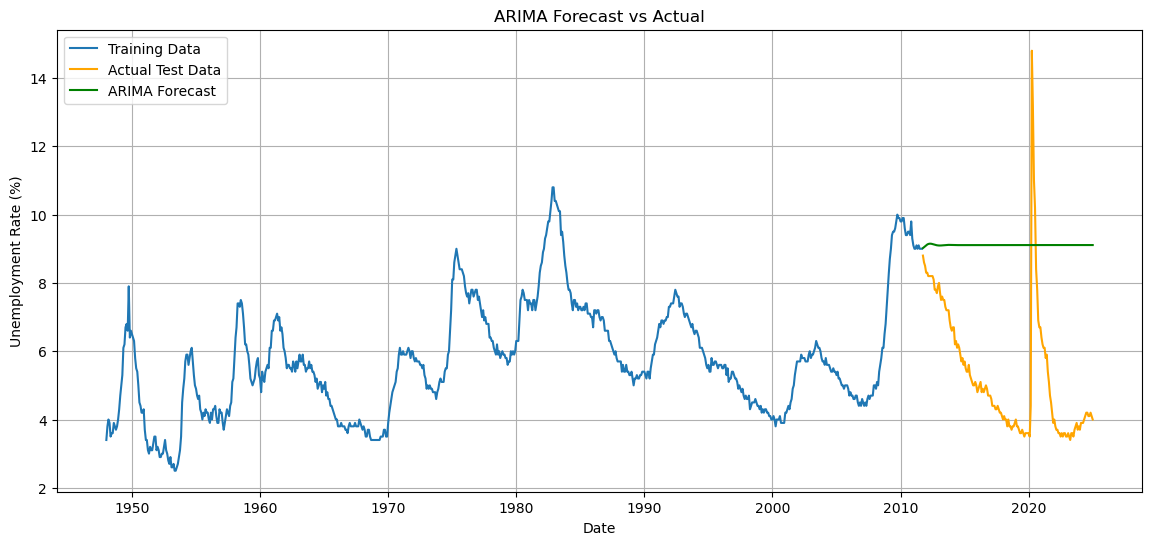

In [41]:
# Forecast 160 future values
forecast_arima = model_arima.predict(n_periods=160)

# Convert forecast to DataFrame and align with test index
forecast_arima = pd.Series(forecast_arima, index=test.index)
print(forecast_arima.head())

# Plot actual vs. forecast
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['unrate'], label='Training Data')
plt.plot(test.index, test['unrate'], label='Actual Test Data', color='orange')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', color='green')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test['unrate']
y_pred = forecast_arima

mae_arima = mean_absolute_error(y_true, y_pred)
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred))
mape_arima = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"ARIMA(2,1,2) MAE: {mae_arima:.4f}")
print(f"ARIMA(2,1,2) RMSE: {rmse_arima:.4f}")
print(f"ARIMA(2,1,2) MAPE: {mape_arima:.2f}%")


ARIMA(2,1,2) MAE: 3.9489
ARIMA(2,1,2) RMSE: 4.2507
ARIMA(2,1,2) MAPE: 90.38%


## Moving to SARIMA

### Fit SARIMA Model

In [45]:


# SARIMA model with yearly seasonality
model_sarima = auto_arima(train['unrate'],
                          seasonal=True,
                          m=12,
                          trace=True,
                          suppress_warnings=True)

model_sarima.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-338.721, Time=2.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-177.810, Time=0.21 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-204.479, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-209.914, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-178.921, Time=0.11 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-308.781, Time=1.94 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-297.356, Time=1.78 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-340.442, Time=4.68 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-321.348, Time=4.44 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-335.778, Time=5.19 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-339.957, Time=4.59 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=-341.915, Time=4.10 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-340.960, Time=1.80 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=-319.995, Time=3.99 sec
 ARIMA(1,1,2)(2,0,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  765
Model:             SARIMAX(2, 1, 2)x(2, 0, [1], 12)   Log Likelihood                 180.219
Date:                              Tue, 06 May 2025   AIC                           -344.437
Time:                                      14:36:58   BIC                           -307.329
Sample:                                  01-01-1948   HQIC                          -330.151
                                       - 09-01-2011                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5164      0.089     17.116      0.000       1.343       1.690
ar.L2         -0.6284      0.086     -7.335      0.000      -0.796      -0.460
ma.L1         -1.4976      0.082    -18.366      0.000      -1.657      -1.338
ma.L2          0.7250      0.067     10.854      0.000       0.594       0.856
ar.S.L12       0.5024      0.075      6.665      0.000       0.355       0.650
ar.S.L24      -0.1180      0.043     -2.772      0.006      -0.201      -0.035
ma.S.L12      -0.7150      0.064    -11.250      0.000      -0.840      -0.590
sigma2         0.0363      0.001     28.600      0.000       0.034       0.039
===================================================================================
Ljung-Box (L1) (Q):                   1.57   Jarque-Bera (JB):              1484.97
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ACF and PACF after fitting SARIMA model (residuals)

<Figure size 1200x500 with 0 Axes>

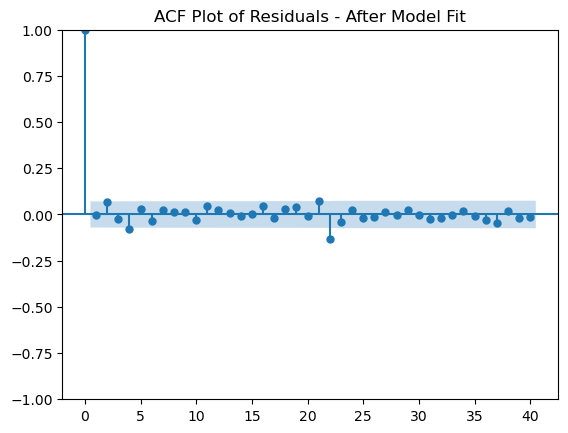

<Figure size 1200x500 with 0 Axes>

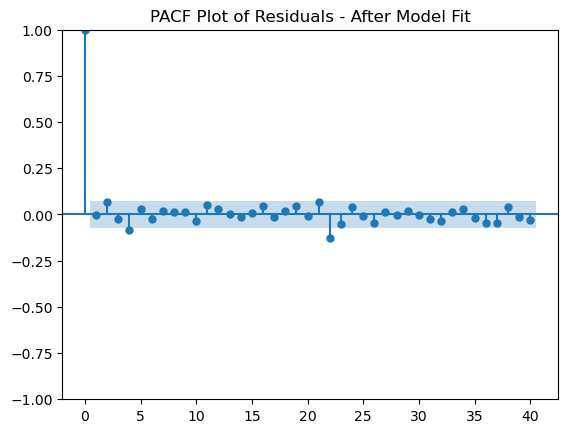

In [47]:
# Assuming 'model' is your ARIMA model fitted on 'train'

# Get residuals
residuals = pd.Series(model_sarima.resid())

# Plot Residuals ACF
plt.figure(figsize=(12,5))
plot_acf(residuals, lags=40)
plt.title('ACF Plot of Residuals - After Model Fit')
plt.show()

# Plot Residuals PACF
plt.figure(figsize=(12,5))
plot_pacf(residuals, lags=40, method='ywm')
plt.title('PACF Plot of Residuals - After Model Fit')
plt.show()


## Plot Residual Diagnostics

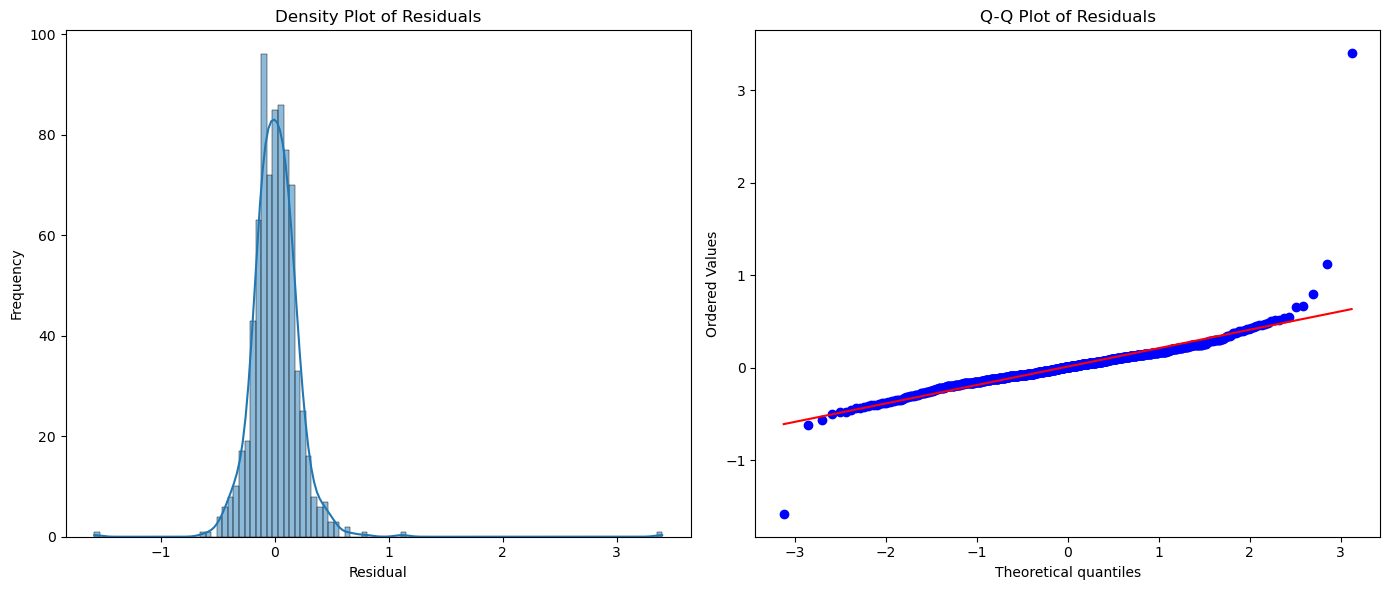

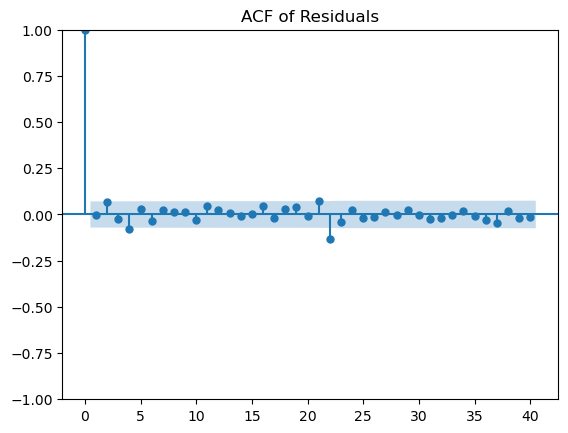

In [49]:
# Extract residuals from the fitted model
residuals = model_sarima.resid()

# Plot residuals
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("Density Plot of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

## SARIMA Residual Diagnostics – Unemployment Rate

### Residual Analysis Summary

#### Density Plot
- Residuals are **centered around zero** and show a nearly **normal distribution**.
- Slight skewness may exist but overall shape is symmetric, indicating good fit.

#### Q-Q Plot
- Points mostly lie along the diagonal line → residuals are approximately **normally distributed**.
- A few deviations at the tails suggest **minor non-normality**, but within acceptable limits.

#### ACF Plot of Residuals
- No significant autocorrelation in residuals → **white noise** behavior.
- Confirms the model has captured most of the time series structure.

---

### Conclusion:
- Residuals show **no pattern**, are **uncorrelated**, and approximately **normally distributed**.
- Indicates the **SARIMA model is a good fit** for forecasting the unemployment rate.



### Forecast & Evaluate SARIMA

observation_date
2011-10-01    8.935104
2011-11-01    8.849530
2011-12-01    8.863001
2012-01-01    8.861054
2012-02-01    8.813905
dtype: float64


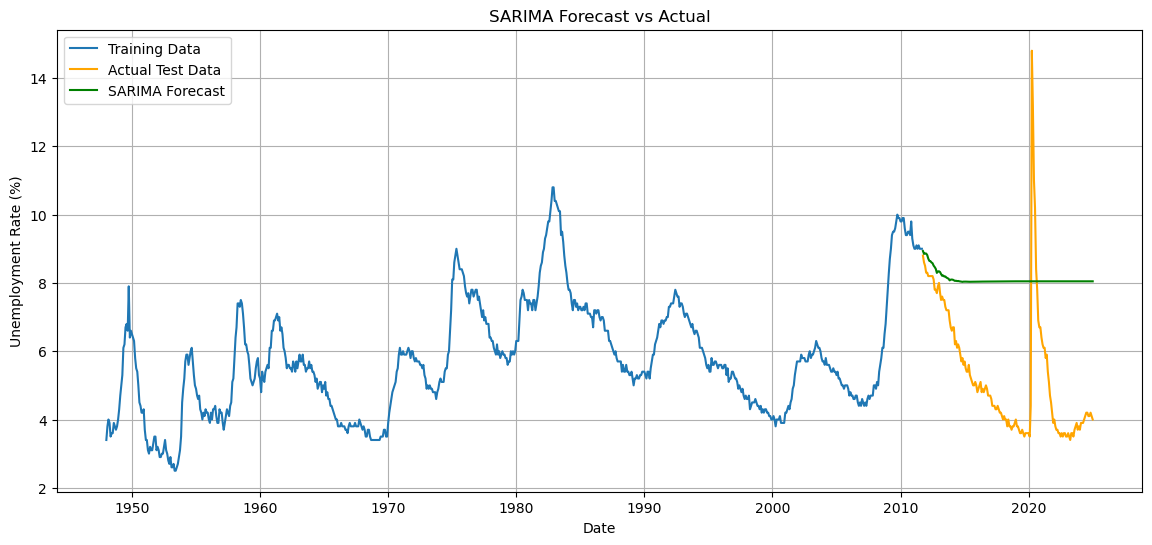

In [52]:
# Forecast 160 future points
forecast_sarima = model_sarima.predict(n_periods=160)
forecast_sarima = pd.Series(forecast_sarima, index=test.index)
print(forecast_sarima.head())
# Plot forecast vs. actual
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['unrate'], label='Training Data')
plt.plot(test.index, test['unrate'], label='Actual Test Data', color='orange')
plt.plot(forecast_sarima.index, forecast_sarima, label='SARIMA Forecast', color='green')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


### Evaluate SARIMA Performance

In [54]:
# True vs Predicted
y_pred_sarima = forecast_sarima

# Compute metrics
mae_sarima = mean_absolute_error(y_true, y_pred_sarima)
rmse_sarima = np.sqrt(mean_squared_error(y_true, y_pred_sarima))
mape_sarima = np.mean(np.abs((y_true - y_pred_sarima) / y_true)) * 100

print(f"SARIMA(2,1,2)(2,0,1)[12] MAE: {mae_sarima:.4f}")
print(f"SARIMA(2,1,2)(2,0,1)[12] RMSE: {rmse_sarima:.4f}")
print(f"SARIMA(2,1,2)(2,0,1)[12] MAPE: {mape_sarima:.2f}%")


SARIMA(2,1,2)(2,0,1)[12] MAE: 3.0097
SARIMA(2,1,2)(2,0,1)[12] RMSE: 3.3412
SARIMA(2,1,2)(2,0,1)[12] MAPE: 69.61%


## Neural Network Forecasting (PyTorch)

In [56]:
# Define window size
window_size = 12

# Scale the full dataset
scaler = MinMaxScaler()
scaled_unrate = scaler.fit_transform(df[['unrate']])

# Create sequences
X, y = [], []
for i in range(len(scaled_unrate) - window_size):
    X.append(scaled_unrate[i:i+window_size])
    y.append(scaled_unrate[i+window_size])


X = np.array(X)
y = np.array(y)

X = X.reshape((X.shape[0], X.shape[1]))  # from (913, 12, 1) to (913, 12)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (913, 12)
y shape: (913, 1)


### Train-Test Split (160 months test)

In [58]:
# Align with previous test size
split_idx = len(X) - 160
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


### Define Neural Network Architecture

In [60]:
class ForecastNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ForecastNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model
model = ForecastNN(input_size=window_size, hidden_size=64, output_size=1)

### Train the Neural Network
- Define Loss Function, Optimizer & Training Loop

In [62]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 100
train_losses = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}")

Epoch 10/100, Loss: 0.009795
Epoch 20/100, Loss: 0.007114
Epoch 30/100, Loss: 0.006316
Epoch 40/100, Loss: 0.004845
Epoch 50/100, Loss: 0.004170
Epoch 60/100, Loss: 0.003542
Epoch 70/100, Loss: 0.002975
Epoch 80/100, Loss: 0.002511
Epoch 90/100, Loss: 0.002454
Epoch 100/100, Loss: 0.002279


### Forecasting & Evaluation
- Predict on Test Set and Inverse Transform

In [64]:
# Set model to eval mode
model.eval()
with torch.no_grad():
    pred_nn = model(X_test_tensor).numpy()

# Inverse transform
y_pred_nn = scaler.inverse_transform(pred_nn)
y_true_nn = scaler.inverse_transform(y_test)

# Convert to Series for plotting
forecast_nn = pd.Series(y_pred_nn.flatten(), index=test.index)
actual_nn = pd.Series(y_true_nn.flatten(), index=test.index)


### Plot Prediction vs Actual

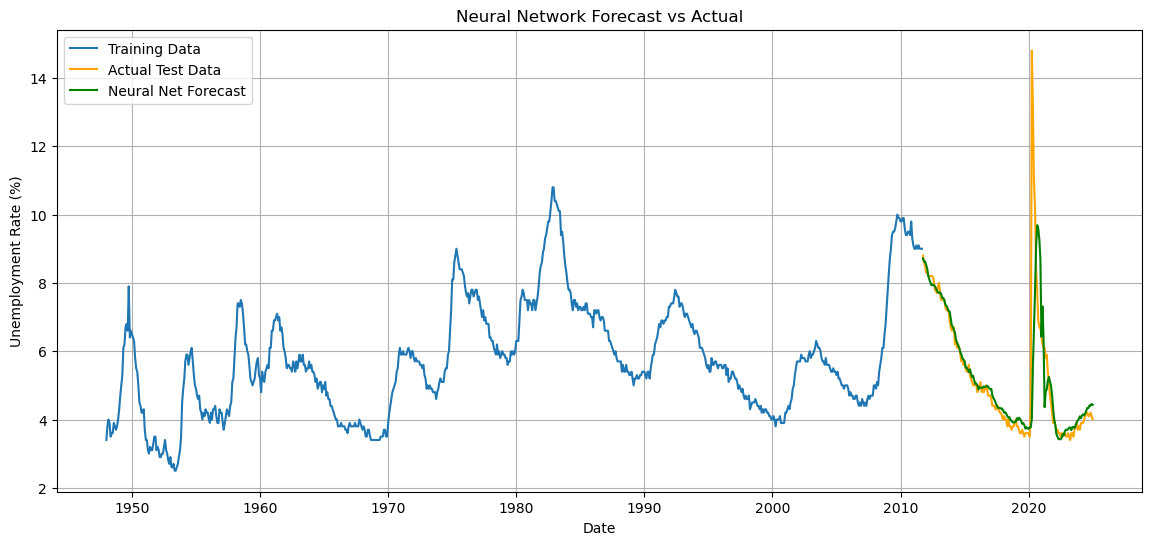

In [66]:
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['unrate'], label='Training Data')
plt.plot(test.index, actual_nn, label='Actual Test Data', color='orange')
plt.plot(test.index, forecast_nn, label='Neural Net Forecast', color='green')
plt.title('Neural Network Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


## This neural network model shows clear signs of **overfitting** based on the forecast plot and training behavior:

1. **Sharp Fluctuations in Forecast Curve**  
   The predicted unemployment rate is **too reactive**, closely following the ups and downs of the actual test data.  
   This behavior indicates that the model is likely **memorizing the noise** rather than learning general trends or patterns.

2. **Low Training Loss, But Possibly High MAPE**  
   While the training loss steadily decreases, the model may still perform poorly on unseen data.  
   This gap often happens when the model fits **specific patterns in training data** that do not generalize to test data.

3. **Visually Overfitting on Noise**  
   The forecast appears **jagged** or excessively responsive, especially during high-volatility periods like the COVID spike.  
   In contrast, a well-generalized model would produce **smoother, more realistic predictions** unless abrupt changes are truly justifiable.

To address this, we will revise the model by adding validation monitoring, increasing dropout, and reducing complexity to improve generalization.


###  Validation Split

In [69]:
# 80% train, 20% validation from existing training data
val_idx = int(0.8 * len(X_train))
X_train_final = X_train[:val_idx]
y_train_final = y_train[:val_idx]
X_val = X_train[val_idx:]
y_val = y_train[val_idx:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_final, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


### Revised Model Definition (Lighter + More Dropout)

In [71]:
class ImprovedForecastNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ImprovedForecastNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)  # increased dropout
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize improved model
model = ForecastNN(input_size=12, hidden_size=32, output_size=1)
model.load_state_dict(torch.load('unrate_nn_model.pkl'))
model.eval()

ForecastNN(
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

### Train with Validation Monitoring + Early Stoppin

In [73]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 200
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10
trigger_times = 0

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

    # Early stopping
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        trigger_times = 0
        best_model_state = model.state_dict()
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/200, Train Loss: 0.002182, Val Loss: 0.010447
Epoch 2/200, Train Loss: 0.010403, Val Loss: 0.001991
Epoch 3/200, Train Loss: 0.002863, Val Loss: 0.001436
Epoch 4/200, Train Loss: 0.004166, Val Loss: 0.003144
Epoch 5/200, Train Loss: 0.006595, Val Loss: 0.001771
Epoch 6/200, Train Loss: 0.004432, Val Loss: 0.000918
Epoch 7/200, Train Loss: 0.002298, Val Loss: 0.002083
Epoch 8/200, Train Loss: 0.002678, Val Loss: 0.003868
Epoch 9/200, Train Loss: 0.003639, Val Loss: 0.004560
Epoch 10/200, Train Loss: 0.004301, Val Loss: 0.003758
Epoch 11/200, Train Loss: 0.003886, Val Loss: 0.002250
Epoch 12/200, Train Loss: 0.002697, Val Loss: 0.001116
Epoch 13/200, Train Loss: 0.002182, Val Loss: 0.000830
Epoch 14/200, Train Loss: 0.002595, Val Loss: 0.001060
Epoch 15/200, Train Loss: 0.003312, Val Loss: 0.001148
Epoch 16/200, Train Loss: 0.003414, Val Loss: 0.000834
Epoch 17/200, Train Loss: 0.002808, Val Loss: 0.000642
Epoch 18/200, Train Loss: 0.002429, Val Loss: 0.000940
Epoch 19/200, Train

### Plot Training vs Validation Loss

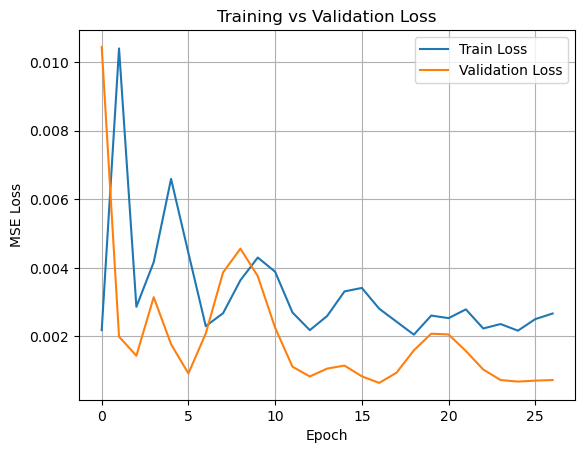

In [75]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
# Load best weights from early stopping
model.load_state_dict(best_model_state)
model.eval()

# Predict on test set
with torch.no_grad():
    pred_nn = model(X_test_tensor).numpy()

# Inverse transform the predictions and actuals
y_pred_nn = scaler.inverse_transform(pred_nn)
y_true_nn = scaler.inverse_transform(y_test)

# Convert to Series for plotting
forecast_nn = pd.Series(y_pred_nn.flatten(), index=test.index)
actual_nn = pd.Series(y_true_nn.flatten(), index=test.index)


### Forecast vs Actual

observation_date
2011-10-01    8.586951
2011-11-01    8.610385
2011-12-01    8.529247
2012-01-01    8.436061
2012-02-01    8.288050
2012-03-01    8.171777
2012-04-01    8.073288
2012-05-01    7.968951
2012-06-01    7.923966
2012-07-01    7.893355
dtype: float32


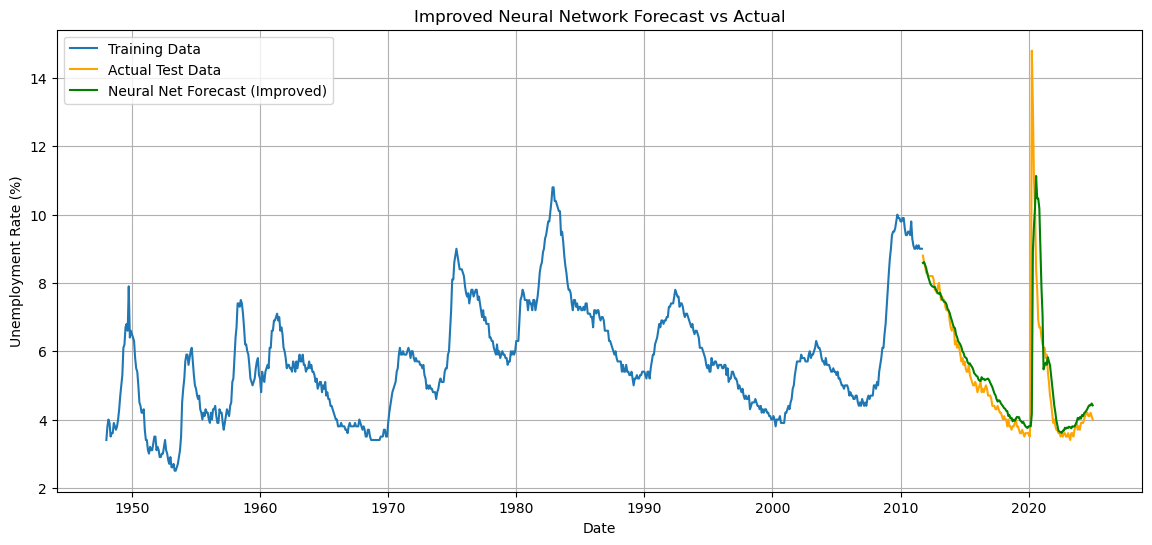

In [78]:
print(forecast_nn.head(10))
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['unrate'], label='Training Data')
plt.plot(test.index, actual_nn, label='Actual Test Data', color='orange')
plt.plot(test.index, forecast_nn, label='Neural Net Forecast (Improved)', color='green')
plt.title('Improved Neural Network Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


### Final Error Metrics

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_nn = mean_absolute_error(actual_nn, forecast_nn)
rmse_nn = np.sqrt(mean_squared_error(actual_nn, forecast_nn))
mape_nn = np.mean(np.abs((actual_nn - forecast_nn) / actual_nn)) * 100

print(f"Improved Neural Net MAE: {mae_nn:.4f}")
print(f"Improved Neural Net RMSE: {rmse_nn:.4f}")
print(f"Improved Neural Net MAPE: {mape_nn:.2f}%")


Improved Neural Net MAE: 0.4491
Improved Neural Net RMSE: 1.1039
Improved Neural Net MAPE: 7.54%


onitoring  


## Final Forecasting Model Evaluation (160-Month Test Set)

| Model                      | MAE    | RMSE   | MAPE     | Notes                                  |
|---------------------------|--------|--------|----------|----------------------------------------|
| ARIMA(2,1,2)              | 3.9489 | 4.2507 | 90.38%   | No seasonality handling; flat forecast |
| SARIMA(2,1,2)(2,0,1)[12]  | 3.0097 | 3.3412 | 69.61%   | Improved fit with seasonality          |
| **Neural Net (Improved)** | **0.4491** | **1.1039** | **7.54%** | Best performance; smooth & reactive |

**Best Model Chosen:** Neural Network (Improved)

- Captured both trend and nonlinear dynamics  
- Outperformed ARIMA/SARIMA in all metrics  
- Avoided overfitting with dropout, early stopping, and validation monitoring  


In [83]:
torch.save(model.state_dict(), 'unrate_nn_model.pkl')

h
pip install streamlit pandas matplotlib torch scikit-learn


# Neural Network Forecasting Chatbot – Project Report

## Overview

This project implements an interactive **Streamlit web application** that forecasts three key U.S. economic indicators using **feedforward neural networks**:

1. **Unemployment Rate (UNRATE)**
2. **Median Sales Price of Houses (MSPUS)**
3. **Federal Funds Rate (FEDFUNDS)**

### The models are trained offline using PyTorch and saved as `.pkl` files for deployment. The chatbot lets users:
- #### Choose the indicator to forecast
- #### Select a future forecast horizon (1–240 months)
- #### Visualize historical trends and future forecasts dynamically

---

## Neural Network Model

Each economic indicator is forecasted using a simple **Feedforward Neural Network** defined by:

- Input Layer: 12 nodes (window of previous 12 months)
- Hidden Layer: 32 neurons + ReLU + Dropout (0.4)
- Output Layer: 1 node (predicts next value)

These models are trained using `MSELoss` and `Adam` optimizer, and saved as `.pkl` files.

---

## Files Used

### Datasets
- `UNRATE.csv` – Monthly U.S. unemployment rate
- `MSPUS.csv` – Quarterly median housing prices in the U.S.
- `FEDFUNDS.csv` – Monthly federal funds rate


### Model Weights (.pkl files)
- `unrate_nn_model.pkl` – Trained model for Unemployment Rate forecasting  
- `mspus_nn_model.pkl` – Trained model for Housing Price forecasting  
- `fedfunds_nn_model.pkl` – Trained model for Federal Funds Rate forecasting

---

## Forecasting Logic

For each selected dataset:
1. Data is **scaled** using `MinMaxScaler`.
2. A sliding window of 12 months is applied to form input sequences.
3. The latest window is used as the **starting seed**.
4. The model recursively forecasts the next `n` months.
5. Outputs are **inverse-transformed** back to the original scale.
6. Historical + forecasted data are plotted using **Matplotlib** and embedded in the Streamlit app.

---

## Running the Application

- ### command to run the bot - **python -m streamlit run chatbot_app_V3.py** 